In [1]:
import torch as th
import torch.optim as optim
import torch.nn.functional as F

import numpy as np

from NN import *
from th_operator import calc_grad
from utils import print_model_layers

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

In [10]:

def mass_cons(network, xy):
    """
    Compute u_x and v_y in PyTorch.
    Args:
        network: PyTorch model for computing u, v, p from inputs.
        xy: network input variables as tensor.
    Returns:
        (u_x, v_y) as tensors.
    """

    xy = th.tensor(xy, requires_grad=True)
    x, y = xy[..., 0].unsqueeze(-1), xy[..., 1].unsqueeze(-1)

    def compute_u_v(xy):
        u_v_p = network(xy)
        u = u_v_p[..., 0].unsqueeze(-1)
        v = u_v_p[..., 1].unsqueeze(-1)
        return u, v

    # Calculate the jacobian with respect to inputs
    u, v = compute_u_v(xy)
    u_x = calc_grad(u, x)
    v_y = calc_grad(v, y)

    return u_x, v_y

def u_0(xy):
    """
    Initial wave form in PyTorch.
    Args:
        xy: variables (x, y) as torch.Tensor.
    Returns:
        u(x, y) as torch.Tensor.
    """
    
    x = xy[..., 0].unsqueeze(-1)
    y = xy[..., 1].unsqueeze(-1)

    return 4 * y * (1 - y)

def contour(x, y, z, title, levels=100):
    """
    Contour plot.
    Args:
        x: x-array.
        y: y-array.
        z: z-array.
        title: title string.
        levels: number of contour lines.
    """

    # get the value range
    vmin = np.min(z)
    vmax = np.max(z)

    # plot a contour
    font1 = {'family':'serif','size':20}
    plt.contour(x, y, z, colors='k', linewidths=0.2, levels=levels)
    contour_filled = plt.contourf(x, y, z, cmap='rainbow', levels=levels, norm=Normalize(vmin=vmin, vmax=vmax))

    # Add the circle patch to the current axes without altering the axes limits
    circle = plt.Circle((0, 0), 1, color='black')
    plt.gca().add_patch(circle)

    plt.title(title, fontdict=font1)
    plt.xlabel("X", fontdict=font1)
    plt.ylabel("Y", fontdict=font1)
    plt.tick_params(axis='both', which='major', labelsize=15)

    # Add colorbar
    cbar = plt.colorbar(contour_filled, pad=0.03, aspect=25, format='%.0e')
    cbar.mappable.set_clim(vmin, vmax)
    cbar.ax.tick_params(labelsize=15)

In [3]:
# Task parameters
u0 = 0.1 # inlet flow velocity
rho = 5000 # density
mu = 0.5 # viscosity

# Samples
num_train_samples = 20000 # number of training samples
num_test_samples = 1000 # number of test samples

# Domain, circle data
x_f =16
x_ini=-4
y_f= 4
y_ini= -4
Cx = 0
Cy = 0
a = 1
b = 1

xyt_circle = np.random.rand(num_train_samples, 2)
xyt_circle[...,0] = 2*(a)*xyt_circle[...,0] +(Cx-a)
xyt_circle[0:num_train_samples//2,1] = b*(1 - (xyt_circle[0:num_train_samples//2,0]-Cx)**2 / a**2)**0.5 + Cy
xyt_circle[num_train_samples//2:,1] = -b*(1 - (xyt_circle[num_train_samples//2:,0]-Cx)**2 / a**2)**0.5 + Cy

# create training input
xyt_eqn = np.random.rand(num_train_samples, 2)
xyt_eqn[...,0] = (x_f - x_ini)*xyt_eqn[...,0] + x_ini
xyt_eqn[...,1] = (y_f - y_ini)*xyt_eqn[...,1] + y_ini

for i in range(num_train_samples):
    while (xyt_eqn[i, 0] - Cx)**2/a**2 + (xyt_eqn[i, 1] - Cy)**2/b**2 < 1:
        xyt_eqn[i, 0] = (x_f - x_ini) * np.random.rand(1, 1) + x_ini
        xyt_eqn[i, 1] = (y_f - y_ini) * np.random.rand(1, 1) + y_ini

xyt_w1 = np.random.rand(num_train_samples, 2)  # top-bottom boundaries
xyt_w1[..., 0] = (x_f - x_ini)*xyt_w1[...,0] + x_ini
xyt_w1[..., 1] =  y_ini          # y-position is 0 or 1

xyt_w2 = np.random.rand(num_train_samples, 2)  # top-bottom boundaries
xyt_w2[..., 0] = (x_f - x_ini)*xyt_w2[...,0] + x_ini
xyt_w2[..., 1] =  y_f

xyt_out = np.random.rand(num_train_samples, 2)  # left-right boundaries
xyt_out[..., 0] = x_f

xyt_in = np.random.rand(num_train_samples, 2)
xyt_in[...,0] = x_ini

x_train = [xyt_eqn, xyt_w1, xyt_w2, xyt_out, xyt_in, xyt_circle]


# create training output
zeros = np.zeros((num_train_samples, 3))

a = u_0(th.tensor(xyt_in, dtype=th.float32)).detach().numpy()
b = np.zeros((num_train_samples, 1))
onze = np.random.permutation(np.concatenate([a,b,a],axis = -1))
y_train = [zeros, onze, zeros, zeros, zeros, zeros]

C:\Users\enomazosii\AppData\Local\Temp\ipykernel_15948\4000574957.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xyt_eqn[i, 0] = (x_f - x_ini) * np.random.rand(1, 1) + x_ini
C:\Users\enomazosii\AppData\Local\Temp\ipykernel_15948\4000574957.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xyt_eqn[i, 1] = (y_f - y_ini) * np.random.rand(1, 1) + y_ini


In [4]:
MLP = MultiLayerPerceptronClass(
    x_dim=2, y_dim=3,
    h_dim_list=[48,48,48,48],
    actv= th.nn.Tanh(),
    p_drop=0.0,
    batch_norm=False
)
print_model_layers(model=MLP, x_torch=th.rand(size=[16,2], dtype=th.float32))
device = th.device("cuda" if th.cuda.is_available() else "cpu")
MLP = MLP.to(device)
pinn = PINN(network=MLP, rho=rho, mu=mu)

batch_size:[16]
[  ] layer:[          input] size:[          16x2]
[ 0] layer:[      linear_00] size:[         16x48] numel:[       768]
[ 1] layer:[        tanh_01] size:[         16x48] numel:[       768]
[ 2] layer:[   dropout1d_02] size:[         16x48] numel:[       768]
[ 3] layer:[      linear_03] size:[         16x48] numel:[       768]
[ 4] layer:[        tanh_04] size:[         16x48] numel:[       768]
[ 5] layer:[   dropout1d_05] size:[         16x48] numel:[       768]
[ 6] layer:[      linear_06] size:[         16x48] numel:[       768]
[ 7] layer:[        tanh_07] size:[         16x48] numel:[       768]
[ 8] layer:[   dropout1d_08] size:[         16x48] numel:[       768]
[ 9] layer:[      linear_09] size:[         16x48] numel:[       768]
[10] layer:[        tanh_10] size:[         16x48] numel:[       768]
[11] layer:[   dropout1d_11] size:[         16x48] numel:[       768]
[12] layer:[      linear_12] size:[          16x3] numel:[        48]


In [ ]:
class L_BFGS_B:
    """
    Optimize the PyTorch model using L-BFGS-B algorithm.
    Attributes:
        model: optimization target model.
        samples: training samples.
    """

    def __init__(self, model, x_train, y_train):
        """
        Args:
            model: optimization target model.
            x_train: training input samples as tensors.
            y_train: training target samples as tensors.
        """
        self.model = model
        self.x_train = x_train
        self.y_train = y_train

        self.optimizer = optim.LBFGS(
            params = self.model.parameters(),
            lr = 1,
            max_iter = 10000,
            tolerance_grad = 1e-7,
            tolerance_change = 1e-9,
            history_size=20,
            line_search_fn="strong_wolfe",
            )

    def evaluate(self):
        """
        Evaluate loss and gradients for the model.
        Returns:
            loss: the loss as a scalar tensor.
        """
        def closure():
            if th.is_grad_enabled():
                self.optimizer.zero_grad()
                
            outputs = self.model(self.x_train)
            
            # 각 output과 y_train의 해당 타겟 사이의 손실을 계산
            # uv_eqn, uv_in, uv_out, uv_w1, uv_w2, uv_circle
            criterion = nn.MSELoss()
            loss_eqn = criterion(outputs[0], self.y_train[0,:])
            loss_in = criterion(outputs[1], self.y_train[1,:])
            loss_out = criterion(outputs[2], self.y_train[2,:])
            loss_w1 = criterion(outputs[3], self.y_train[3,:])
            loss_w2 = criterion(outputs[4], self.y_train[4,:])
            loss_circle = criterion(outputs[5], self.y_train[5,:])

            # 총 손실을 계산
            total_loss = (loss_eqn + loss_in + loss_out + loss_w1 + loss_w2 + loss_circle) / 6
            
            if total_loss.requires_grad:
                total_loss.backward()
            return total_loss

        return closure

    def fit(self, max_iter=20, log_interval=1):
        """
        Train the model using L-BFGS-B algorithm.
        Args:
            max_iter: Maximum number of iterations.
        """
        self.model.train()
        # Optimize
        for iter in range(max_iter):
            loss = self.optimizer.step(self.evaluate())
            
            print(f"{iter}:{loss}")   
        print('Optimization finished.')
        
    def predict(self, x):
        """
        Predict using the trained model.
        Args:
            x: Input data for prediction.
        Returns:
            predictions: Predicted values by the model.
        """
        self.model.eval()  # 모델을 평가 모드로 설정
        with th.no_grad():  # 그라디언트 계산 비활성화
            predictions = self.model(x)
        return predictions

In [5]:
class L_BFGS_B:
    """
    Optimize the PyTorch model using L-BFGS-B algorithm.
    Attributes:
        model: optimization target model.
        samples: training samples.
    """

    def __init__(self, model, x_train, y_train):
        """
        Args:
            model: optimization target model.
            x_train: training input samples as tensors.
            y_train: training target samples as tensors.
        """
        self.model = model
        self.x_train = x_train
        self.y_train = y_train

        self.optimizer = optim.LBFGS(
            params = self.model.parameters(),
            lr = 1,
            max_iter = 10000,
            tolerance_grad = 1e-7,
            tolerance_change = 1e-9,
            history_size=20,
            line_search_fn="strong_wolfe",
            )

    def evaluate(self):
        """
        Evaluate loss and gradients for the model.
        Returns:
            loss: the loss as a scalar tensor.
        """
        def closure():
            if th.is_grad_enabled():
                self.optimizer.zero_grad()
                
            outputs = self.model(self.x_train)
            
            # 각 output과 y_train의 해당 타겟 사이의 손실을 계산
            # uv_eqn, uv_in, uv_out, uv_w1, uv_w2, uv_circle
            criterion = nn.MSELoss()
            loss_eqn = criterion(outputs[0], self.y_train[0,:])
            loss_in = criterion(outputs[1], self.y_train[1,:])
            loss_out = criterion(outputs[2], self.y_train[2,:])
            loss_w1 = criterion(outputs[3], self.y_train[3,:])
            loss_w2 = criterion(outputs[4], self.y_train[4,:])
            loss_circle = criterion(outputs[5], self.y_train[5,:])

            # 총 손실을 계산
            total_loss = (loss_eqn + loss_in + loss_out + loss_w1 + loss_w2 + loss_circle) / 6
            
            if total_loss.requires_grad:
                total_loss.backward()
            return total_loss

        return closure

    def fit(self, max_iter=20, log_interval=1):
        """
        Train the model using L-BFGS-B algorithm.
        Args:
            max_iter: Maximum number of iterations.
        """
        self.model.train()
        # Optimize
        for iter in range(max_iter):
            loss = self.optimizer.step(self.evaluate())
            
            print(f"{iter}:{loss}")   
        print('Optimization finished.')
        
    def predict(self, x):
        """
        Predict using the trained model.
        Args:
            x: Input data for prediction.
        Returns:
            predictions: Predicted values by the model.
        """
        self.model.eval()  # 모델을 평가 모드로 설정
        with th.no_grad():  # 그라디언트 계산 비활성화
            predictions = self.model(x)
        return predictions

In [6]:
# Train the model
x_train = th.tensor(x_train, dtype=th.float32)
y_train = th.tensor(y_train, dtype=th.float32)
# 데이터를 GPU로 이동
x_train = x_train.to(device)
y_train = y_train.to(device)

lbfgs = L_BFGS_B(model=pinn, x_train=x_train, y_train=y_train)
lbfgs.fit()

C:\Users\enomazosii\AppData\Local\Temp\ipykernel_15948\1191769340.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  x_train = th.tensor(x_train, dtype=th.float32)


0:0.7251719236373901
1:0.009755812585353851
2:0.009755769744515419
3:0.009754515253007412
4:0.009754198603332043
5:0.009754098951816559
6:0.009754091501235962
7:0.00975407287478447
8:0.009754020720720291
9:0.00975401233881712
10:0.009753993712365627
11:0.009753922931849957
12:0.00975382886826992
13:0.009753772988915443
14:0.009753748774528503
15:0.00975374411791563
16:0.009753731079399586
17:0.009753567166626453
18:0.009753558784723282
19:0.009753537364304066
Optimization finished.


In [7]:
th.save(MLP.state_dict(), "./model_state_dict.pth")

---

In [8]:
MLP = MultiLayerPerceptronClass(
    x_dim=2, y_dim=3,
    h_dim_list=[48,48,48,48],
    actv= th.nn.Tanh(),
    p_drop=0.0,
    batch_norm=False
)

MLP.load_state_dict(th.load("./model_state_dict.pth"))
device = th.device("cuda" if th.cuda.is_available() else "cpu")
MLP = MLP.to(device)
MLP.eval()

MultiLayerPerceptronClass(
  (actv): Tanh()
  (net): Sequential(
    (linear_00): Linear(in_features=2, out_features=48, bias=True)
    (tanh_01): Tanh()
    (dropout1d_02): Dropout1d(p=0.0, inplace=False)
    (linear_03): Linear(in_features=48, out_features=48, bias=True)
    (tanh_04): Tanh()
    (dropout1d_05): Dropout1d(p=0.0, inplace=False)
    (linear_06): Linear(in_features=48, out_features=48, bias=True)
    (tanh_07): Tanh()
    (dropout1d_08): Dropout1d(p=0.0, inplace=False)
    (linear_09): Linear(in_features=48, out_features=48, bias=True)
    (tanh_10): Tanh()
    (dropout1d_11): Dropout1d(p=0.0, inplace=False)
    (linear_12): Linear(in_features=48, out_features=3, bias=True)
  )
)

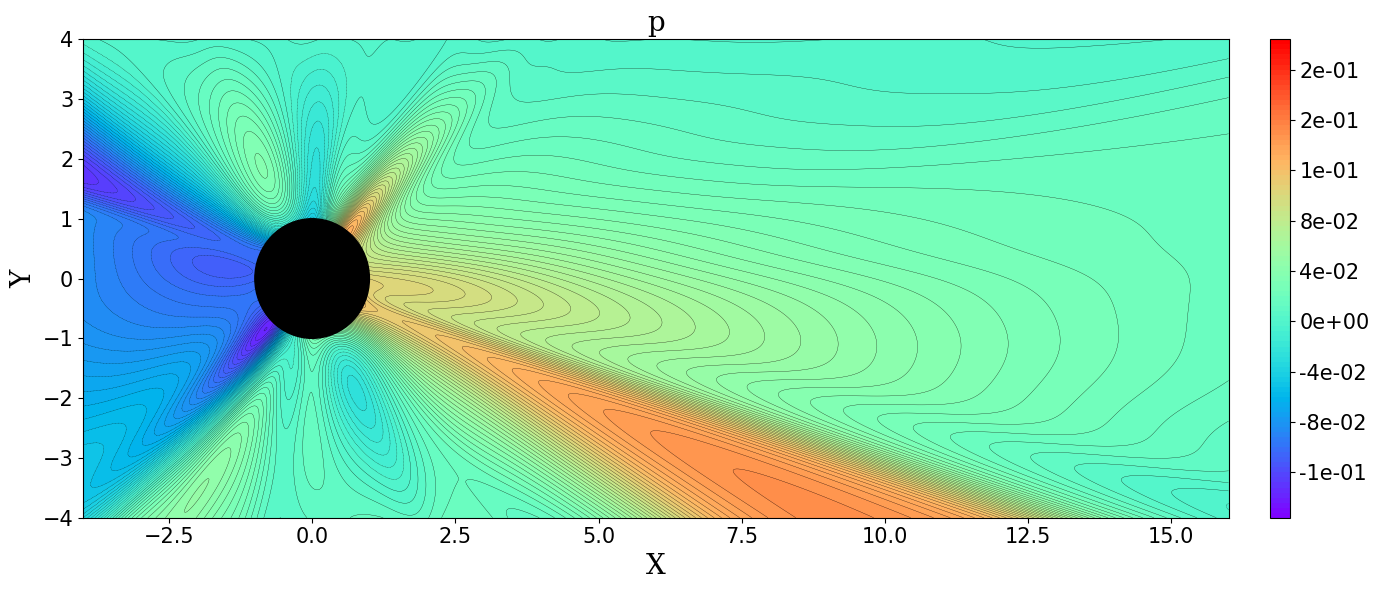

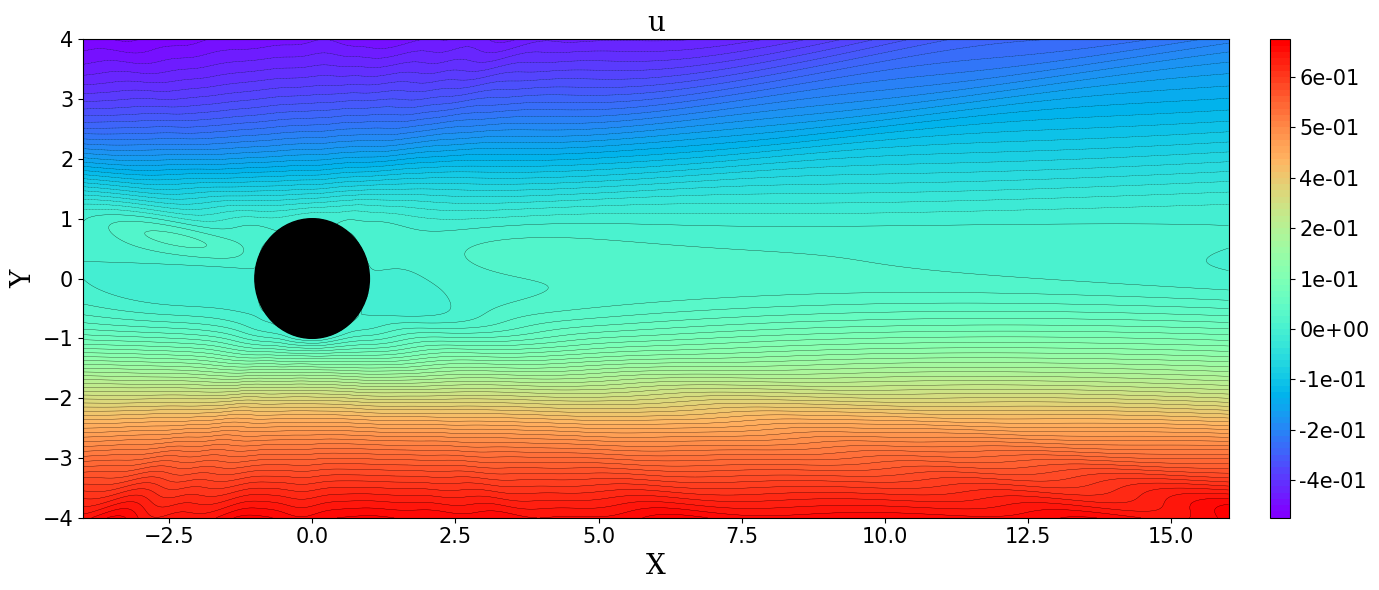

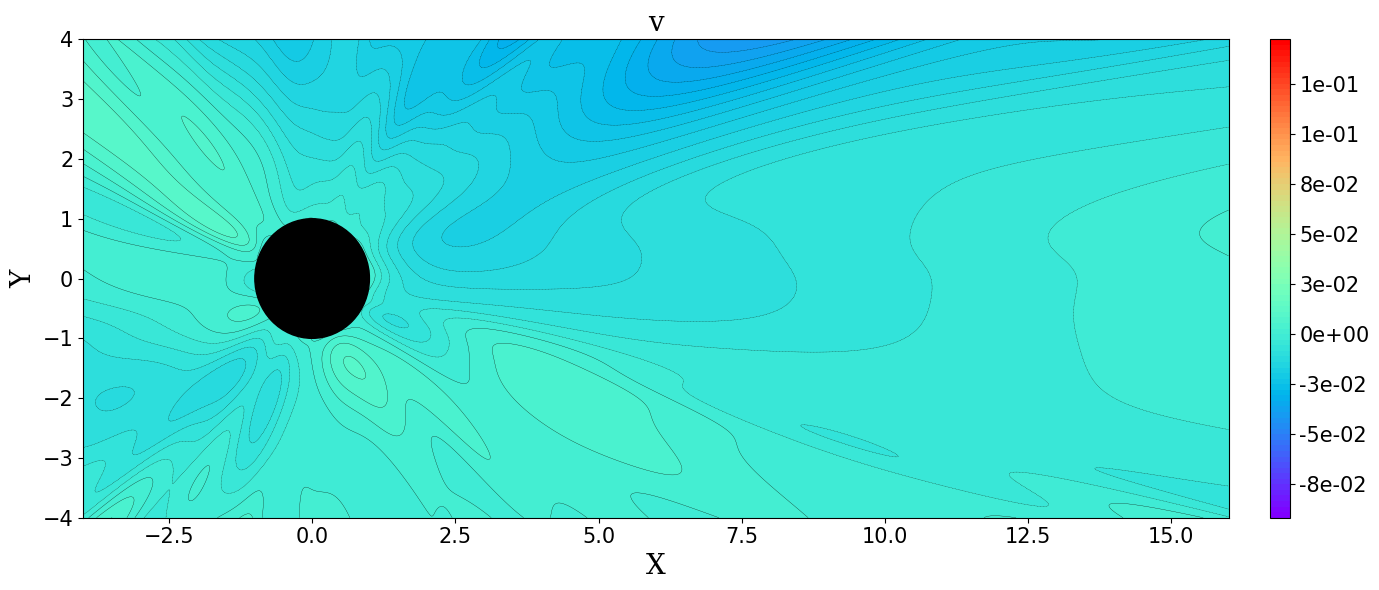

In [12]:
x = np.linspace(x_ini, x_f, num_test_samples)
y = np.linspace(y_ini, y_f, num_test_samples)
x, y = np.meshgrid(x, y)
xy = np.stack([x.flatten(), y.flatten()], axis=-1)
xy = th.tensor(xy, dtype=th.float32).to(device)
# predict (psi, p)
MLP.eval()
u_v_p, output_lists = MLP(xy)
    
u, v, p = [ u_v_p[..., i].reshape(x.shape) for i in range(u_v_p.shape[-1]) ]
u = u.detach().cpu().numpy()
v = v.detach().cpu().numpy()
p = p.detach().cpu().numpy()
# compute (u, v)
u = u.reshape(x.shape)
v = v.reshape(x.shape)
p = p.reshape(x.shape)

# plot test results
fig = plt.figure(figsize=(15, 6))
contour(x, y, p, 'p')
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(15, 6))
contour(x, y, u, 'u')
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(15, 6))
contour(x, y, v, 'v')
plt.tight_layout()
plt.show()